In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchsummary
from torch import nn
from models import CNN_2d
from torch.optim.lr_scheduler import ExponentialLR
from batch import get_batch_2d

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
cnn_2d = CNN_2d()
cnn_2d = cnn_2d.to(device)
torchsummary.summary(cnn_2d, (1, 512, 512))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 512, 512]             160
         AvgPool2d-2         [-1, 16, 256, 256]               0
            Conv2d-3         [-1, 32, 256, 256]           4,640
         AvgPool2d-4         [-1, 32, 128, 128]               0
            Conv2d-5         [-1, 64, 128, 128]          18,496
         AvgPool2d-6           [-1, 64, 64, 64]               0
            Conv2d-7          [-1, 128, 64, 64]          73,856
         AvgPool2d-8          [-1, 128, 32, 32]               0
            Conv2d-9          [-1, 128, 32, 32]         147,584
        AvgPool2d-10          [-1, 128, 16, 16]               0
           Linear-11                 [-1, 2048]      67,110,912
           Linear-12                 [-1, 2048]       4,196,352
           Linear-13                    [-1, 9]          18,441
Total params: 71,570,441
Trainable para

In [3]:
# Params
batch_size = 20
epochs = 2500
lr = 0.001
filter_method = 'abs_nofit'
datasets_root = './datasets'
train_dataset = 'nodemcu-random-train2'
test_dataset = 'nodemcu-random-test2'

In [ ]:
# train 
dataset_names = [train_dataset]
model = cnn_2d
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
# optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
scheduler = ExponentialLR(optimizer, gamma=0.9)
# 
batch_c = []  # Batch container
for dataset_name in dataset_names:
    dataset_path = os.path.join(datasets_root, dataset_name)
    dataset_files = list(os.listdir(dataset_path))
    total_batch = len([f for f in dataset_files if '_traces.npy' in f])*16//batch_size
    
    for epoch in range(epochs):
        cnt = 0
        for i, dataset_file in enumerate(dataset_files):
            if '_traces.npy' in dataset_file:
                for batch in get_batch_2d(dataset_path, dataset_file, batch_c, batch_size=batch_size):
                    input = np.stack(batch[:, 0], axis=0)[:, np.newaxis, ...]
                    label = np.stack(batch[:, 1], axis=0)            
                    
                    if np.isnan(input).any():
                        continue
                    
                    xs = torch.tensor(input).float().to(device)
                    ys = torch.tensor(label).float().to(device)

                    y_pred = model(xs)
                    loss = criterion(y_pred, ys)
                    
                    cnt += 1
                    if cnt % 100 == 0:
                        print('Epoch: {}/{}'.format(epoch, epochs), 'Batch： {}/{}'.format(cnt, total_batch), 'Loss={}'.format(loss.cpu().item()), sep=', ')

                    optimizer.zero_grad()
                    loss.backward()
                    torch.nn.utils.clip_grad_norm_(model.parameters(), 5)
                    optimizer.step()
        scheduler.step()
        # saving model every epoch
        torch.save(model.state_dict(), f"models/cnn2d_{epoch}.pt")
print('Training done')

test model: ./models/cnn2d_99.pt


C:\Users\Juncheng\AppData\Local\miniconda3\envs\pytorch\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Juncheng\AppData\Local\miniconda3\envs\pytorch\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Juncheng\AppData\Local\miniconda3\envs\pytorch\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

              precision    recall  f1-score   support

           0       0.89      0.23      0.37       422
           1       0.00      0.00      0.00       474
           2       0.00      0.00      0.00       470
           3       0.70      0.57      0.63       449
           4       1.00      0.99      0.99       479
           5       0.14      1.00      0.25       449
           6       0.00      0.00      0.00       461
           7       0.00      0.00      0.00       426
           8       0.00      0.00      0.00       450

    accuracy                           0.31      4080
   macro avg       0.30      0.31      0.25      4080
weighted avg       0.30      0.31      0.25      4080


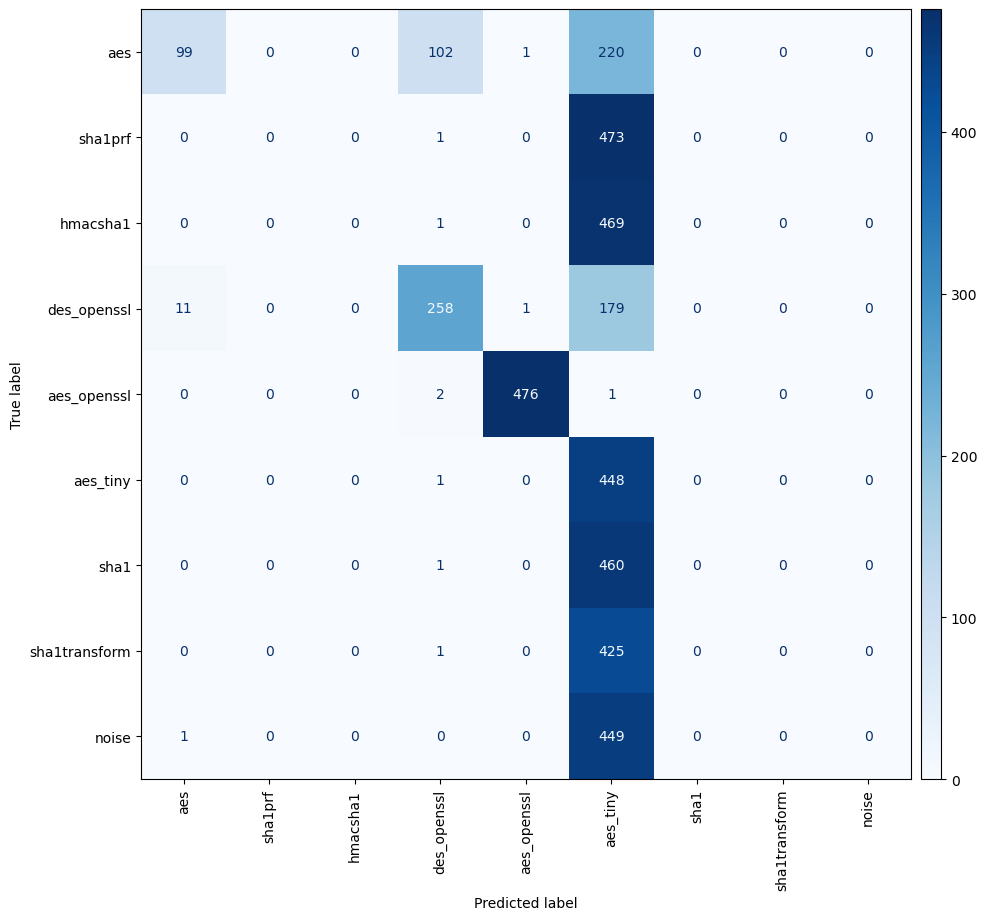

In [3]:
# Validate
model_path = './models/cnn2d_99.pt'
test_dataset = 'nodemcu-random-test2'
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

print('test model: ' + model_path)  
datasets_root = "./datasets"


model = CNN_2d()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.load_state_dict(torch.load(model_path))
model.to(device)

test_dataset_path = os.path.join(datasets_root, test_dataset)
test_dataset_files = list(os.listdir(test_dataset_path))

batch_c = []

true_labels = []
pred_labels = []
for i, dataset_file in enumerate(test_dataset_files):
    if '_traces.npy' in dataset_file:
        for batch in get_batch_2d(test_dataset_path, dataset_file, batch_c, batch_size=20):

            input = np.stack(batch[:, 0], axis=0)[:, np.newaxis, ...]
            label = np.stack(batch[:, 1], axis=0) 
            if np.isnan(input).any():
                continue

            xs = torch.tensor(input).float().to(device)
            ys = torch.tensor(label).float().to(device)

            y_pred = model(xs)
            y_pred = y_pred.detach().cpu().numpy()
            
            true_labels.extend(np.argmax(label, axis=1).tolist())
            pred_labels.extend(np.argmax(y_pred, axis=1).tolist())

            
print(classification_report(true_labels, pred_labels))
cm = confusion_matrix(true_labels, pred_labels)
cmp = ConfusionMatrixDisplay(cm, display_labels=["aes", "sha1prf", "hmacsha1", "des_openssl", "aes_openssl", "aes_tiny", "sha1", "sha1transform", "noise"])
fig, ax = plt.subplots(figsize=(10, 10))
cmp.plot(ax=ax, cmap=plt.cm.Blues, xticks_rotation='vertical', colorbar=False)
cax = fig.add_axes([ax.get_position().x1 + 0.01, ax.get_position().y0, 0.02, ax.get_position().height])
plt.colorbar(cmp.im_, cax=cax)
plt.show()